In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_ID = "meta-llama/Llama-3.2-1B"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=2,
    problem_type="single_label_classification",
)

print("Model OK!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model OK!


## Project Setting

In [3]:
MODEL_ID = "meta-llama/Llama-3.2-1B"
TRAIN_PATH = "commonsense_15k.json"
TEST_PATH = "test.csv"
OUTPUT_ROOT = "./llama32_1b_team_lora"

## Data Preprocessing (Training data)

In [4]:
import json
import re
from dataclasses import dataclass
from typing import List, Dict, Optional

import torch
from torch.utils.data import Dataset, random_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

warnings.filterwarnings("ignore", category=FutureWarning)


def extract_options_from_instruction(instruction: str, answer_format: str) -> List[str]:
    if "true/false" in answer_format.lower():
        return ["true", "false"]

    formats = {
        "Answer": r"Answer\d+:",
        "Solution": r"Solution\d+:",
        "Ending": r"Ending\d+:",
        "Option": r"Option\d+:",
    }

    detected = None
    for fmt, pattern in formats.items():
        if re.search(pattern, instruction):
            detected = fmt
            break

    if detected is None:
        return None

    boundary = (
        rf"(?=\s*{detected}\d+:|\s*Answer format:|\s*Solution format:|$)"
    )

    pattern = rf"({detected}\d+:\s*.*?){boundary}"
    matches = re.findall(pattern, instruction, re.DOTALL)

    clean_options = []
    for m in matches:
        m = m.strip()
        # remove prefix: Answer1:, Option2:, Solution3:, Ending4:
        cleaned = re.sub(rf"^{detected}\d+:\s*", "", m)
        clean_options.append(cleaned.strip())

    return clean_options


def parse_answer_key(answer: str) -> str:
    answer = answer.lower().strip()

    if answer in ["true", "false"]:
        return answer

    solution_match = re.search(r"solution(\d+)", answer)
    if solution_match:
        return f"solution{solution_match.group(1)}"

    answer_match = re.search(r"answer(\d+)", answer)
    if answer_match:
        return f"answer{answer_match.group(1)}"

    ending_match = re.search(r"ending(\d+)", answer)
    if ending_match:
        return f"ending{ending_match.group(1)}"

    option_match = re.search(r"option(\d+)", answer)
    if option_match:
        return f"option{option_match.group(1)}"

    return answer


def get_correct_option_index(parsed_answer: str, options: List[str]) -> int:
    if parsed_answer in ["true", "false"]:
        try:
            return options.index(parsed_answer)
        except ValueError:
            return -1

    number_match = re.search(r"(\d+)", parsed_answer)
    if number_match:
        return int(number_match.group(1)) - 1

    return -1


class TeamBinaryDataset(Dataset):
    def __init__(self, path: str, tokenizer, max_length: int = 512):
        self.samples = []
        self.tokenizer = tokenizer
        self.max_length = max_length

        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
            for item in data:
                question = self._extract_question(item["instruction"])
                answer_format = self._extract_answer_format(item["instruction"]) # ex: true/false, answer1/answer2/answer3

                options = extract_options_from_instruction(item["instruction"], answer_format)
                if not options:
                    continue

                parsed_answer = parse_answer_key(item["answer"])
                correct_idx = get_correct_option_index(parsed_answer, options)

                if correct_idx == -1:
                    continue

                for i, option in enumerate(options):
                    text = self.build_text(question, option)
                    label = 1 if i == correct_idx else 0
                    self.samples.append({"text": text, "label": label})

    def _extract_question(self, instruction: str) -> str:
        """
        Extract the question as: everything before the first blank line (\n\n).
        If no blank line exists, return the full first paragraph.
        """
        # Normalize line endings
        text = instruction.replace("\r\n", "\n")

        # Split using first blank line
        parts = text.split("\n\n", 1)

        # Take the first chunk as question
        question = parts[0].strip()

        return question

    def _extract_answer_format(self, instruction: str) -> str:
        format_match = re.search(r"Answer format:\s*([^\n]+)", instruction, re.IGNORECASE)
        if format_match:
            return format_match.group(1).strip()
        return ""

    def build_text(self, question: str, candidate_answer: str) -> str:
        if len(candidate_answer) > 200:
            candidate_answer = candidate_answer[:200] + "..."

        return f"Question: {question}\nAnswer: {candidate_answer}\n"

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        encoded = self.tokenizer(

            item["text"],
            truncation=True,
            max_length=self.max_length,
        )
        encoded["labels"] = item["label"]
        return encoded

### Check dataset

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

dataset = TeamBinaryDataset(TRAIN_PATH, tokenizer, max_length=512)

print(f"Total samples: {len(dataset)}")
print("-" * 50)
for i in range(40000, 40005):
    sample = dataset[i]
    text = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
    label = sample['labels']
    print(f"\nSample {i+1} (Label: {label}):")
    print(text)
    print("-" * 50)

Total samples: 46475
--------------------------------------------------

Sample 40001 (Label: 1):
Question: Please choose the correct answer to the question: What would be passed down from parents to their children?
Answer: head size

--------------------------------------------------

Sample 40002 (Label: 0):
Question: Please choose the correct answer to the question: What would be passed down from parents to their children?
Answer: number of friends

--------------------------------------------------

Sample 40003 (Label: 0):
Question: Please choose the correct answer to the question: What would be passed down from parents to their children?
Answer: sports played

--------------------------------------------------

Sample 40004 (Label: 1):
Question: Please choose the correct answer to the question: Meadow voles consume
Answer: producers

--------------------------------------------------

Sample 40005 (Label: 0):
Question: Please choose the correct answer to the question: Meadow vole

## LoRA

1. What is LoRA? Why low-rank? Include the ∆W = BA formulation; discuss
parameter-efficiency and deployment benefits. (1%)
2. Where to attach LoRA in a Transformer? Explain q proj, k proj, v proj,
o proj (attention) and up proj, down proj, gate proj (FFN).

In [5]:
# ================== LoRA settings ==================
LORA_SETTINGS = {
    "attn_light": {
        "description": 'ATTN—light: ["q_proj", "v_proj"]',
        "target_modules": ["q_proj", "v_proj"],
    },
    "attn_ffn_medium": {
        "description": 'ATTN+FFN—medium: ["q_proj","k_proj","v_proj","up_proj","down_proj"]',
        "target_modules": ["q_proj", "k_proj", "v_proj", "up_proj", "down_proj"],
    },
    "full_heavy": {
        "description": 'Full—heavy: ["q_proj","k_proj","v_proj","o_proj","up_proj","down_proj","gate_proj"]',
        "target_modules": [
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "up_proj",
            "down_proj",
            "gate_proj",
        ],
    },
}

## Trainer

In [6]:
def make_lora_model(base_model, target_modules: List[str]):
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        bias="none",
        target_modules=target_modules,
        task_type="SEQ_CLS",  # sequence classification
    )
    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()
    return model


def train_one_setting(
    setting_name: str,
    target_modules: List[str],
    dataset: TeamBinaryDataset,
    tokenizer,
    num_epochs: int = 3,
):
    print(f"\n========== Training setting: {setting_name} ==========")
    print(f"Target modules: {target_modules}")

    # 1. split train/val
    val_ratio = 0.1
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # 2. base model + LoRA
    base_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_ID,
        num_labels=2,
        problem_type="single_label_classification",
    )
    model = make_lora_model(base_model, target_modules)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    out_dir = os.path.join(OUTPUT_ROOT, setting_name)
    os.makedirs(out_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=out_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        learning_rate=5e-5,
        weight_decay=0.01,
        warmup_ratio=0.03,
        logging_steps=50,
        save_strategy="epoch",
        eval_strategy="epoch",
        fp16=torch.cuda.is_available(),
        report_to=[],
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        data_collator=data_collator,
        processing_class=tokenizer,
    )

    trainer.train()
    trainer.save_model(out_dir)
    tokenizer.save_pretrained(out_dir)

    log_history = trainer.state.log_history

    train_losses = []   # (epoch, loss)
    eval_losses = []    # (epoch, loss)

    for log in log_history:
        if "loss" in log and "epoch" in log and "eval_loss" not in log:
            train_losses.append((log["epoch"], log["loss"]))
        if "eval_loss" in log and "epoch" in log:
            eval_losses.append((log["epoch"], log["eval_loss"]))

    return {
        "train_losses": train_losses,
        "eval_losses": eval_losses,
    }

## Training


========== Training setting: attn_light ==========
Target modules: ['q_proj', 'v_proj']


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 856,064 || all params: 1,236,674,560 || trainable%: 0.0692


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.


Epoch,Training Loss,Validation Loss
1,2.150400,0.558193
2,1.992000,0.513951
3,1.810700,0.521581
4,1.771900,0.518609
5,1.747800,0.516775


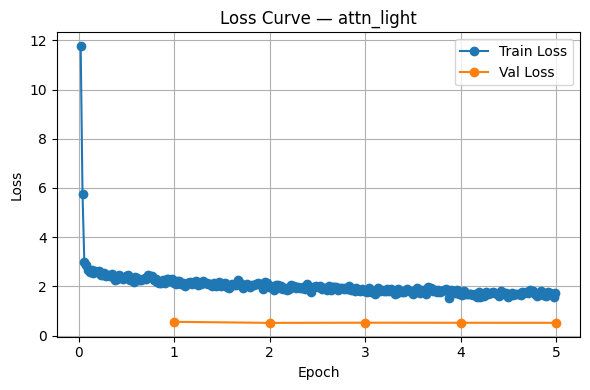

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

full_dataset = TeamBinaryDataset(TRAIN_PATH, tokenizer, max_length=512)

setting_name = "attn_light"
target_modules = LORA_SETTINGS[setting_name]["target_modules"]

curves = train_one_setting(
    setting_name=setting_name,
    target_modules=target_modules,
    dataset=full_dataset,
    tokenizer=tokenizer,
    num_epochs=5,
)

# Plot
plt.figure(figsize=(6,4))
if len(curves["train_losses"]) > 0:
    epochs, losses = zip(*curves["train_losses"])
    plt.plot(epochs, losses, marker="o", label="Train Loss")

if len(curves["eval_losses"]) > 0:
    epochs, losses = zip(*curves["eval_losses"])
    plt.plot(epochs, losses, marker="o", label="Val Loss")

plt.title(f"Loss Curve — {setting_name}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


========== Training setting: attn_ffn_medium ==========
Target modules: ['q_proj', 'k_proj', 'v_proj', 'up_proj', 'down_proj']


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3,805,184 || all params: 1,239,623,680 || trainable%: 0.3070


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.


Epoch,Training Loss,Validation Loss
1,2.026400,0.536539
2,1.793000,0.487445
3,1.547400,0.520470
4,1.325600,0.586968


Epoch,Training Loss,Validation Loss
1,2.026400,0.536539
2,1.793000,0.487445
3,1.547400,0.520470
4,1.325600,0.586968
5,0.884000,0.764861


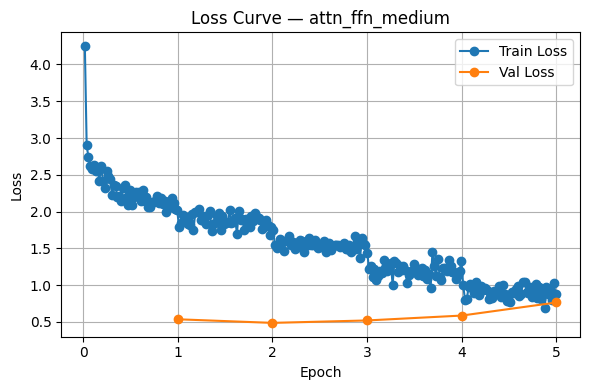

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

full_dataset = TeamBinaryDataset(TRAIN_PATH, tokenizer, max_length=512)

setting_name = "attn_ffn_medium"
target_modules = LORA_SETTINGS[setting_name]["target_modules"]

curves = train_one_setting(
    setting_name=setting_name,
    target_modules=target_modules,
    dataset=full_dataset,
    tokenizer=tokenizer,
    num_epochs=5,
)

# Plot
plt.figure(figsize=(6,4))
if len(curves["train_losses"]) > 0:
    epochs, losses = zip(*curves["train_losses"])
    plt.plot(epochs, losses, marker="o", label="Train Loss")

if len(curves["eval_losses"]) > 0:
    epochs, losses = zip(*curves["eval_losses"])
    plt.plot(epochs, losses, marker="o", label="Val Loss")

plt.title(f"Loss Curve — {setting_name}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


========== Training setting: full_heavy ==========
Target modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'up_proj', 'down_proj', 'gate_proj']


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 5,640,192 || all params: 1,241,458,688 || trainable%: 0.4543


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.


Epoch,Training Loss,Validation Loss
1,2.061600,0.507546
2,1.753500,0.483136
3,1.459800,0.520305


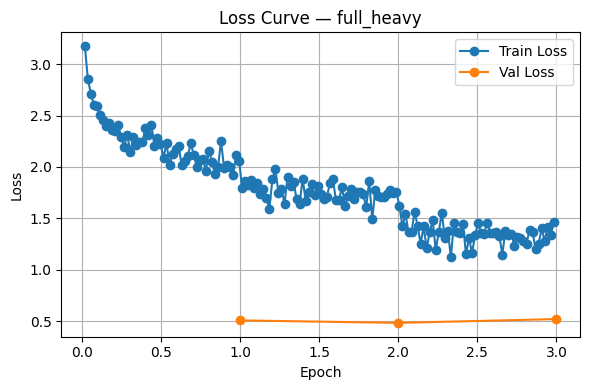

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

full_dataset = TeamBinaryDataset(TRAIN_PATH, tokenizer, max_length=512)

setting_name = "full_heavy"
target_modules = LORA_SETTINGS[setting_name]["target_modules"]

curves = train_one_setting(
    setting_name=setting_name,
    target_modules=target_modules,
    dataset=full_dataset,
    tokenizer=tokenizer,
    num_epochs=3,
)

# Plot
plt.figure(figsize=(6,4))
if len(curves["train_losses"]) > 0:
    epochs, losses = zip(*curves["train_losses"])
    plt.plot(epochs, losses, marker="o", label="Train Loss")

if len(curves["eval_losses"]) > 0:
    epochs, losses = zip(*curves["eval_losses"])
    plt.plot(epochs, losses, marker="o", label="Val Loss")

plt.title(f"Loss Curve — {setting_name}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1. Trainable Parameters: Report programmatic counts (and optional estimates).
2. Resources: Record peak VRAM and epoch time; discuss scaling from light →heavy

Ablation and Analysis
* When did you obtain the highest validation accuracy/F1?
* Which setting achieves the best performance–parameter trade-off ?
* Tie observations to module roles (q/k/v/o for routing vs. up/down/gate for semantic
capacity).

## Data Preprocessing (Test data)

In [9]:
class TestDataset(Dataset):
    def __init__(self, test_data: pd.DataFrame, tokenizer, max_length: int = 512):
        self.samples = []
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.test_ids = []

        for idx, row in test_data.iterrows():
            test_id = row['id']
            instruction = row['instruction']

            question = self._extract_question(instruction)
            answer_format = self._extract_answer_format(instruction)
            options = extract_options_from_instruction(instruction, answer_format)

            if not options:
                continue

            for i, option in enumerate(options):
                text = self.build_text(question, option)
                self.samples.append({
                    "text": text,
                    "test_id": test_id,
                    "option_idx": i,
                    "option_text": option
                })
                self.test_ids.append(test_id)

    def _extract_question(self, instruction: str) -> str:
        if "question:" in instruction.lower():
            question_start = instruction.lower().find("question:")
            question_part = instruction[question_start + 9:]

            answer_start = float('inf')
            for pattern in ["Answer1:", "Solution1:", "Ending1:", "Option1:"]:
                pos = question_part.find(pattern)
                if pos != -1 and pos < answer_start:
                    answer_start = pos

            if answer_start != float('inf'):
                question = question_part[:answer_start].strip()
            else:
                question = question_part.strip()
            return question

        lines = instruction.split('\n')
        for line in lines:
            if line.strip() and not any(keyword in line for keyword in
                                      ['Answer1:', 'Solution1:', 'Ending1:', 'Option1:']):
                return line.strip()

        return instruction.split('\n')[0].strip() if instruction else ""

    def _extract_answer_format(self, instruction: str) -> str:
        if "Answer1:" in instruction:
            return "answer1/answer2/answer3/answer4"
        elif "Solution1:" in instruction:
            return "solution1/solution2"
        elif "Ending1:" in instruction:
            return "ending1/ending2/ending3/ending4"
        elif "Option1:" in instruction:
            return "option1/option2"
        return ""

    def build_text(self, question: str, candidate_answer: str) -> str:
        if len(candidate_answer) > 200:
            candidate_answer = candidate_answer[:200] + "..."

        return f"Question: {question}\nAnswer: {candidate_answer}\n"

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        encoded = self.tokenizer(
            item["text"],
            truncation=True,
            max_length=self.max_length,
        )

        return {
            **encoded,
            "test_id": item["test_id"],
            "option_idx": item["option_idx"],
            "option_text": item["option_text"]
        }

### Check dataset

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

test_data = pd.read_csv(TEST_PATH)

test_ds = TestDataset(test_data, tokenizer)

for i in range(5):
    print(f"\n----- RAW Sample {i} -----")
    print(test_ds.samples[i]["text"])


----- RAW Sample 0 -----
Question: An astronomer observes that a planet rotates faster after a meteorite impact. Which is the most likely effect of this increase in rotation?
Answer: Planetary density will decrease.


----- RAW Sample 1 -----
Question: An astronomer observes that a planet rotates faster after a meteorite impact. Which is the most likely effect of this increase in rotation?
Answer: Planetary years will become longer.


----- RAW Sample 2 -----
Question: An astronomer observes that a planet rotates faster after a meteorite impact. Which is the most likely effect of this increase in rotation?
Answer: Planetary days will become shorter.


----- RAW Sample 3 -----
Question: An astronomer observes that a planet rotates faster after a meteorite impact. Which is the most likely effect of this increase in rotation?
Answer: Planetary gravity will become stronger.


----- RAW Sample 4 -----
Question: A group of engineers wanted to know how different building designs would respon

## Inference

In [12]:
def custom_collate_fn(batch):
    tokenizer_keys = ['input_ids', 'attention_mask']
    extra_keys = ['test_id', 'option_idx', 'option_text']

    tokenizer_batch = {}
    for key in tokenizer_keys:
        if key in batch[0]:
            tokenizer_batch[key] = [item[key] for item in batch]

    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    collated = data_collator(tokenizer_batch)

    for key in extra_keys:
        if key in batch[0]:
            collated[key] = [item[key] for item in batch]

    return collated

def predict_with_lora_model(model_path: str, test_csv_path: str, output_csv_path: str, tokenizer):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    test_data = pd.read_csv(test_csv_path)
    print(f"Loading {len(test_data)} test samples")

    test_dataset = TestDataset(test_data, tokenizer, max_length=512)

    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        collate_fn=custom_collate_fn
    )

    from peft import PeftModel
    base_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_ID,
        num_labels=2,
        problem_type="single_label_classification",
        pad_token_id=tokenizer.pad_token_id,
    )

    if hasattr(base_model, 'config'):
        base_model.config.pad_token_id = tokenizer.pad_token_id

    model = PeftModel.from_pretrained(base_model, model_path)
    model.to(device)
    model.eval()

    predictions = {}  # test_id -> {option_idx: probability}

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            test_ids = batch["test_id"]
            option_indices = batch["option_idx"]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = torch.softmax(outputs.logits, dim=1)[:, 1]

            for test_id, option_idx, prob in zip(test_ids, option_indices, probabilities):
                if test_id not in predictions:
                    predictions[test_id] = {}
                predictions[test_id][option_idx] = prob.item()

    results = []
    for test_id, options in predictions.items():
        best_option_idx = max(options.keys(), key=lambda k: options[k])

        test_row = test_data[test_data['id'] == test_id]['instruction'].iloc[0]
        if "Answer" in test_row:
            answer_label = f"answer{best_option_idx + 1}"
        elif "Solution" in test_row:
            answer_label = f"solution{best_option_idx + 1}"
        elif "Ending" in test_row:
            answer_label = f"ending{best_option_idx + 1}"
        elif "Option" in test_row:
            answer_label = f"option{best_option_idx + 1}"
        else:
            answer_label = f"answer{best_option_idx + 1}"

        results.append({
            "id": test_id,
            "answer": answer_label
        })

    result_df = pd.DataFrame(results)
    result_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to: {output_csv_path}")
    print(f"Predicted {len(results)} samples")

    return result_df

def run_inference_for_all_settings(test_csv_path: str, output_dir: str):
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    os.makedirs(output_dir, exist_ok=True)

    for setting_name in LORA_SETTINGS.keys():
        print(f"\n========== Using {setting_name} model for prediction ==========")

        model_path = os.path.join(OUTPUT_ROOT, setting_name)
        output_csv = os.path.join(output_dir, f"predictions_{setting_name}.csv")

        try:
            predict_with_lora_model(
                model_path=model_path,
                test_csv_path=test_csv_path,
                output_csv_path=output_csv,
                tokenizer=tokenizer
            )
        except Exception as e:
            print(f"Error occurred while predicting {setting_name}: {e}")

In [13]:
test_csv_path = "test.csv"
output_dir = "./predictions"

# run_inference_for_all_settings(test_csv_path, output_dir)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

predict_with_lora_model(
    model_path="./llama32_1b_team_lora/full_heavy",
    test_csv_path=test_csv_path,
    output_csv_path="final_predictions.csv",
    tokenizer=tokenizer
)

Loading 1172 test samples


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 586/586 [09:10<00:00,  1.06it/s]


Predictions saved to: final_predictions.csv
Predicted 1172 samples


,id,answer
0,ARC_test_000000,answer3
1,ARC_test_000001,answer2
2,ARC_test_000002,answer2
3,ARC_test_000003,answer4
4,ARC_test_000004,answer1
...,...,...
1167,ARC_test_001167,answer1
1168,ARC_test_001168,answer1
1169,ARC_test_001169,answer1
1170,ARC_test_001170,answer4
